In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE =64
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


# Load Data

In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image /= 255  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
#         layers.experimental.preprocessing.RandomTranslation(
#             height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#         layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [7]:
tf.random.set_seed(SEED)
load_dir = os.getcwd() + '/data' #'/kaggle/input/ranzcr-clip-catheter-line-classification'

df_train = pd.read_csv('./data/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

In [18]:
train_ds = prepare_data(df_train, augment=False)

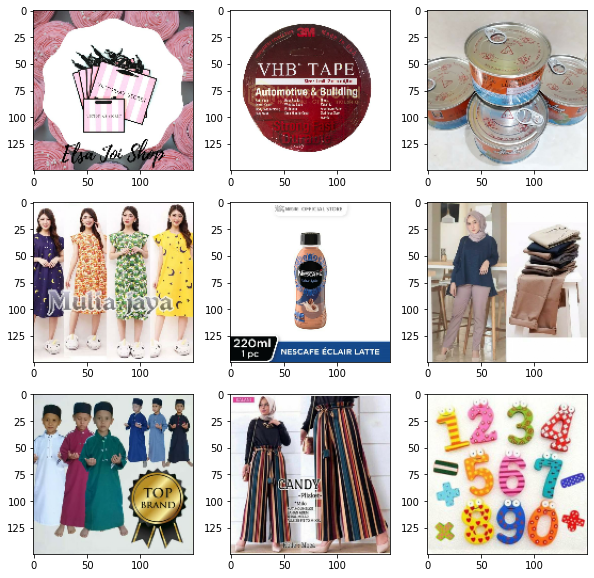

In [27]:
plt.figure(figsize=(10, 10))
for i, image_path, in enumerate(df_train['image_paths'][:9]):
    plt.subplot(3, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image)
    plt.imshow(image)
plt.show()

# Model

In [28]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

In [30]:
embeddings = model.predict(train_ds)

In [32]:
embeddings.shape

(34250, 1280)